In [1]:
import torch
import torch.nn as nn
from torchvision.datasets.svhn import SVHN
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, transforms
from torch.utils.data.dataloader import DataLoader

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

In [4]:
def load_data(transformation, model_name):
    svhn_train = SVHN(root='./Deep Learning', split='train',
                      download=True, transform=transformation)
    svhn_test = SVHN(root='./Deep Learning', split='test',
                     download=True, transform=transformation)

    t_split, v_split = train_test_split(
        svhn_train, test_size=0.30, random_state=2)

    train_loader = DataLoader(t_split, batch_size=25)
    val_loader = DataLoader(v_split, batch_size=25)
    test_loader = DataLoader(svhn_test, batch_size=25)

    return train_loader, val_loader, test_loader

In [5]:
def visualize(loader):
    for images, _ in loader:
        print('Shape:', images.shape)
        plt.figure(figsize=(16, 8))
        plt.axis('off')
        plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break

In [6]:
def plot_curves(train, val, kind):
    plt.figure()
    plt.plot(train, label=f'Train {kind}')
    plt.plot(val, label=f'Val {kind}')
    plt.xlabel('Epochs')
    plt.ylabel(kind)
    plt.legend()
    plt.show()

In [7]:
def train_model(model, model_name, train_loader, val_loader):
    cost = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 5
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')

    print('Current Device:', device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print('*'*80)
    print(f'Now Training:: {model_name}')
    print('*'*80)

    for epoch in range(epochs):

        # Training
        model.train()
        tot_train_loss = 0
        train_correct = 0
        train_tot = 0

        tick = time.time()

        for batch_id, (imgs, labels) in enumerate(train_loader):
            # Sending the data to the device
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Fwd Pass
            out = model(imgs)
            loss = cost(out, labels)

            # Bwd Pass
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()*imgs.size(0)

            x, pred = torch.max(out, 1)
            train_correct += (pred == labels).sum().item()
            train_tot += labels.size(0)

        train_loss = tot_train_loss/len(train_loader.dataset)
        train_acc = train_correct/train_tot
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        tot_val_loss = 0
        val_correct = 0
        val_tot = 0

        with torch.no_grad():
            for val_imgs, val_labels in val_loader:
                val_imgs = val_imgs.to(device)
                val_labels = val_labels.to(device)

                val_out = model(val_imgs)
                vloss = cost(val_out, val_labels)
                tot_val_loss += vloss.item()*val_imgs.size(0)

                _, val_pred = torch.max(val_out, 1)
                val_correct += (val_pred == val_labels).sum().item()
                val_tot += val_labels.size(0)

        val_loss = tot_val_loss/len(val_loader.dataset)
        val_acc = val_correct/val_tot
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        tock = time.time()
        tot_time = tock-tick

        print(f'Epoch:{epoch+1}\t Train_Loss: {train_loss:.4f}\t Val_Loss: {val_loss:.4f}\t Train_Acc: {train_acc:.4f}\t Val_Acc: {val_acc:.4f}\t Time: {tot_time:.2f} seconds')

    plot_curves(train_accs, val_accs, kind='Accuracy')
    plot_curves(train_losses, val_losses, kind='Loss')

    return model

In [8]:
def evaluate_model(model, model_name, test_loader):

    model.eval()
    all_labels = []
    preds = []
    labels = [test_loader.dataset[i][1] for i in range(len(test_loader))]
    # print(test_loader.dataset[0])
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    print('Current Device:', device)

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            out = model(imgs)
            _, pred = torch.max(out, 1)

            all_labels.extend(labels.cpu().numpy())
            preds.extend(pred.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels, preds, target_names=[str(i) for i in range(10)]))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
    disp.plot()
    plt.tight_layout()
    disp.ax_.set_xticklabels(labels=[str(i) for i in range(10)], rotation=70)
    plt.show()

In [9]:
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

In [10]:
model_lenet = LeNet()

In [11]:
LeNet_transformer = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
LeNet_train_loader, LeNet_val_loader, LeNet_test_loader = load_data(
    LeNet_transformer, 'LeNet-5')

Using downloaded and verified file: ./Deep Learning/train_32x32.mat
Using downloaded and verified file: ./Deep Learning/test_32x32.mat


Shape: torch.Size([25, 1, 32, 32])


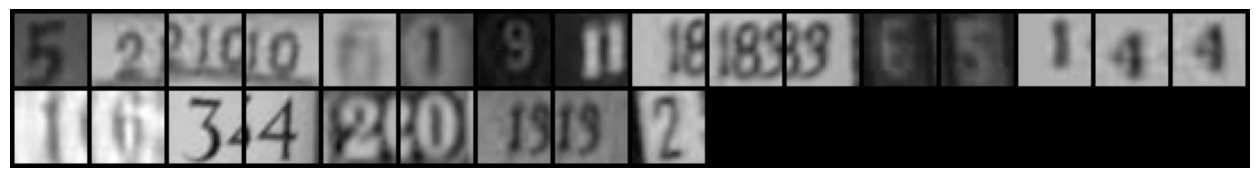

In [12]:
visualize(LeNet_test_loader)

Current Device: cpu
********************************************************************************
Now Training:: LeNet-5
********************************************************************************
Epoch:1	 Train_Loss: 1.1889	 Val_Loss: 0.6530	 Train_Acc: 0.6084	 Val_Acc: 0.8098	 Time: 9.84 seconds
Epoch:2	 Train_Loss: 0.5612	 Val_Loss: 0.5261	 Train_Acc: 0.8353	 Val_Acc: 0.8478	 Time: 10.52 seconds
Epoch:3	 Train_Loss: 0.4605	 Val_Loss: 0.4634	 Train_Acc: 0.8629	 Val_Acc: 0.8648	 Time: 9.81 seconds
Epoch:4	 Train_Loss: 0.4097	 Val_Loss: 0.4469	 Train_Acc: 0.8770	 Val_Acc: 0.8678	 Time: 9.89 seconds
Epoch:5	 Train_Loss: 0.3756	 Val_Loss: 0.4323	 Train_Acc: 0.8875	 Val_Acc: 0.8727	 Time: 11.90 seconds


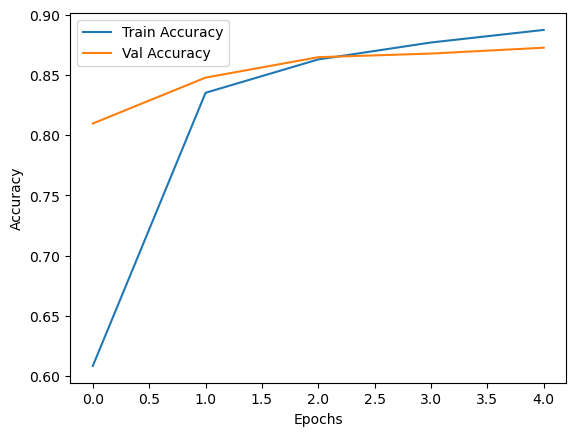

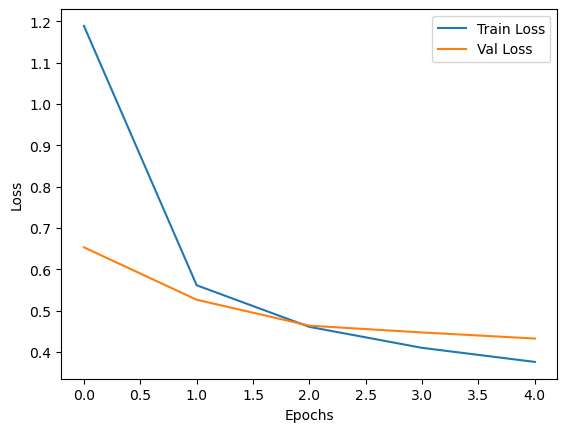

In [13]:
model_lenet = train_model(model_lenet, 'LeNet-5',
                          LeNet_train_loader, LeNet_val_loader)

Current Device: cpu
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1744
           1       0.93      0.91      0.92      5099
           2       0.89      0.90      0.89      4149
           3       0.80      0.82      0.81      2882
           4       0.84      0.89      0.86      2523
           5       0.85      0.84      0.84      2384
           6       0.81      0.80      0.80      1977
           7       0.85      0.90      0.87      2019
           8       0.79      0.78      0.78      1660
           9       0.79      0.83      0.81      1595

    accuracy                           0.86     26032
   macro avg       0.85      0.85      0.85     26032
weighted avg       0.86      0.86      0.86     26032

Confusion Matrix:


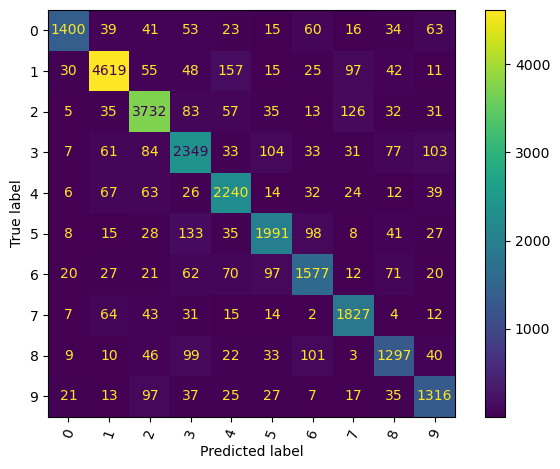

In [14]:
evaluate_model(model_lenet, 'LeNet-5', LeNet_test_loader)

In [15]:
from torchvision.models import AlexNet, AlexNet_Weights, alexnet

In [16]:
model_alex = alexnet(weights=AlexNet_Weights)

/Users/tharun/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for param in model_alex.parameters():
    param.requires_grad = False
model_alex.classifier[6] = nn.Linear(
    in_features=4096, out_features=10)

In [18]:
AlexNet_transformer = transforms.Compose([
    transforms.Resize(size=((63, 63))),
    transforms.ToTensor()
])
AlexNet_train_loader, AlexNet_val_loader, AlexNet_test_loader = load_data(
    AlexNet_transformer, 'AlexNet-5')

Using downloaded and verified file: ./Deep Learning/train_32x32.mat
Using downloaded and verified file: ./Deep Learning/test_32x32.mat


Shape: torch.Size([25, 3, 63, 63])


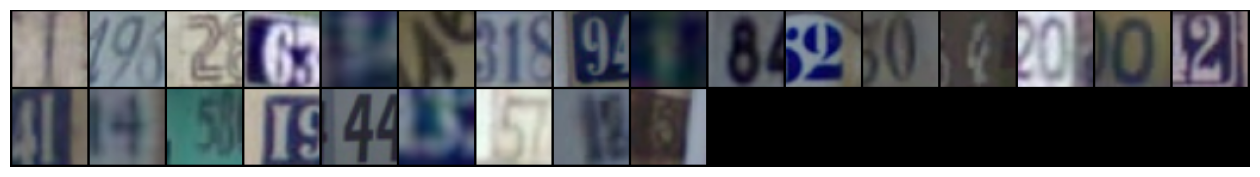

In [19]:
visualize(AlexNet_val_loader)

Current Device: cpu
********************************************************************************
Now Training:: AlexNet
********************************************************************************
Epoch:1	 Train_Loss: 1.8425	 Val_Loss: 1.5962	 Train_Acc: 0.4006	 Val_Acc: 0.4585	 Time: 185.31 seconds
Epoch:2	 Train_Loss: 1.8034	 Val_Loss: 1.6057	 Train_Acc: 0.4203	 Val_Acc: 0.4437	 Time: 207.17 seconds
Epoch:3	 Train_Loss: 1.7984	 Val_Loss: 1.5371	 Train_Acc: 0.4262	 Val_Acc: 0.4762	 Time: 234.98 seconds
Epoch:4	 Train_Loss: 1.8004	 Val_Loss: 1.5354	 Train_Acc: 0.4257	 Val_Acc: 0.4809	 Time: 239.06 seconds
Epoch:5	 Train_Loss: 1.7970	 Val_Loss: 1.5242	 Train_Acc: 0.4311	 Val_Acc: 0.4853	 Time: 222.23 seconds


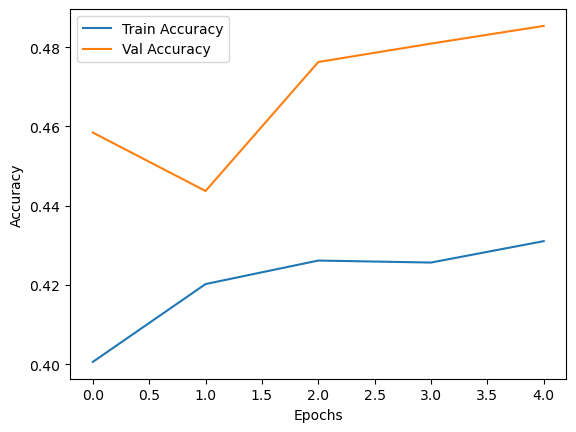

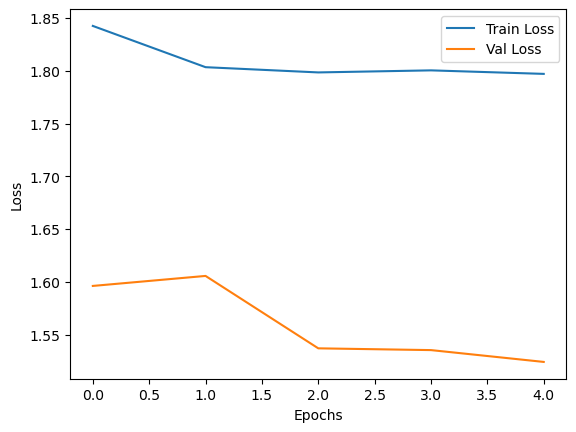

In [20]:
model_alex = train_model(model_alex, 'AlexNet',
                         AlexNet_train_loader, AlexNet_val_loader)

Current Device: cpu
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.61      1744
           1       0.69      0.80      0.74      5099
           2       0.57      0.38      0.46      4149
           3       0.31      0.16      0.21      2882
           4       0.57      0.46      0.51      2523
           5       0.23      0.79      0.36      2384
           6       0.36      0.30      0.33      1977
           7       0.76      0.37      0.50      2019
           8       0.32      0.02      0.04      1660
           9       0.34      0.31      0.33      1595

    accuracy                           0.46     26032
   macro avg       0.49      0.41      0.41     26032
weighted avg       0.51      0.46      0.45     26032

Confusion Matrix:


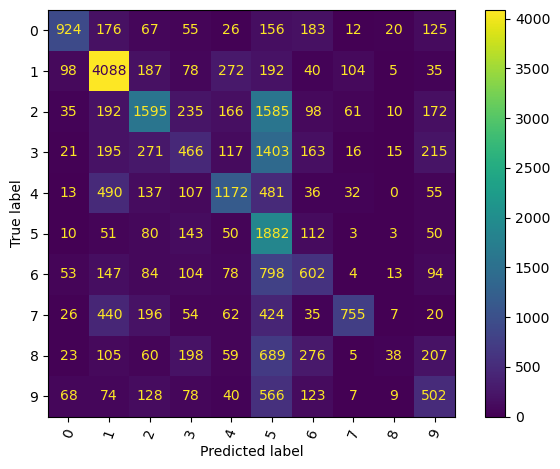

In [21]:
evaluate_model(model_alex, 'AlexNet', AlexNet_test_loader)

In [22]:
from torchvision.models import vgg16, VGG16_Weights
model_vgg = vgg16(weights=VGG16_Weights)

/Users/tharun/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier[6] = nn.Linear(
    in_features=4096, out_features=10)

In [24]:
VGG_transformer = transforms.Compose([
    transforms.ToTensor()
])
VGG_train_loader, VGG_val_loader, VGG_test_loader = load_data(
    VGG_transformer, 'VGG-16')

Using downloaded and verified file: ./Deep Learning/train_32x32.mat
Using downloaded and verified file: ./Deep Learning/test_32x32.mat


Shape: torch.Size([25, 3, 32, 32])


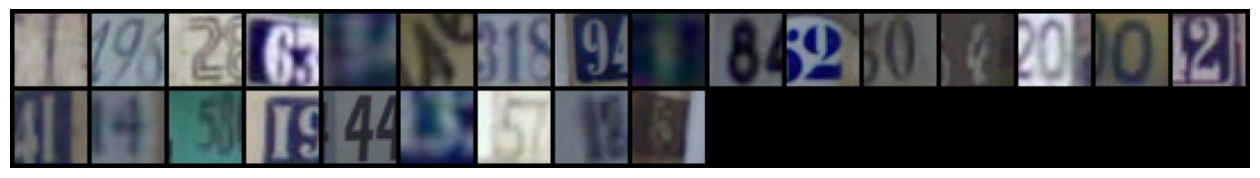

In [25]:
visualize(VGG_val_loader)

Current Device: cpu
********************************************************************************
Now Training:: VGG-16
********************************************************************************
Epoch:1	 Train_Loss: 2.1454	 Val_Loss: 1.7506	 Train_Acc: 0.3177	 Val_Acc: 0.3924	 Time: 1092.87 seconds
Epoch:2	 Train_Loss: 2.1640	 Val_Loss: 1.7058	 Train_Acc: 0.3341	 Val_Acc: 0.4109	 Time: 1105.46 seconds
Epoch:3	 Train_Loss: 2.1791	 Val_Loss: 1.7136	 Train_Acc: 0.3335	 Val_Acc: 0.4128	 Time: 868.08 seconds
Epoch:4	 Train_Loss: 2.1904	 Val_Loss: 1.7158	 Train_Acc: 0.3343	 Val_Acc: 0.4106	 Time: 643.94 seconds
Epoch:5	 Train_Loss: 2.1809	 Val_Loss: 1.7091	 Train_Acc: 0.3388	 Val_Acc: 0.4096	 Time: 637.29 seconds


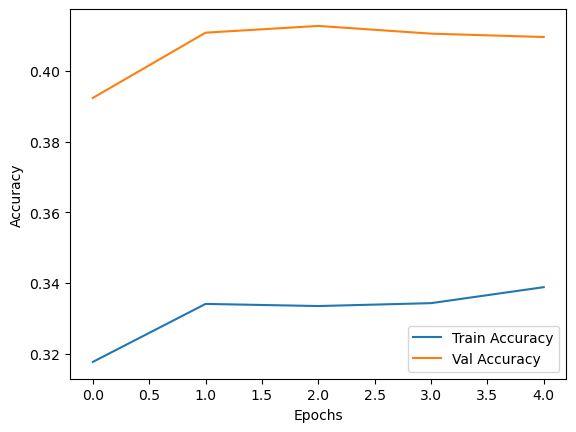

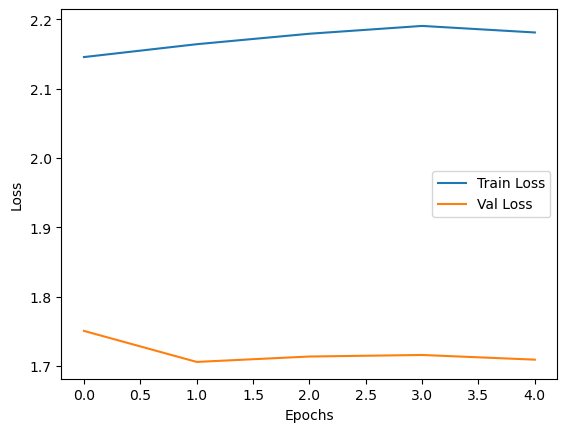

In [26]:
model_vgg = train_model(model_vgg, 'VGG-16', VGG_train_loader, VGG_val_loader)

Current Device: cpu
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.47      0.48      1744
           1       0.67      0.59      0.63      5099
           2       0.43      0.52      0.47      4149
           3       0.29      0.14      0.19      2882
           4       0.34      0.53      0.41      2523
           5       0.31      0.36      0.34      2384
           6       0.31      0.49      0.38      1977
           7       0.48      0.37      0.42      2019
           8       0.25      0.24      0.24      1660
           9       0.37      0.12      0.18      1595

    accuracy                           0.42     26032
   macro avg       0.40      0.38      0.37     26032
weighted avg       0.43      0.42      0.41     26032

Confusion Matrix:


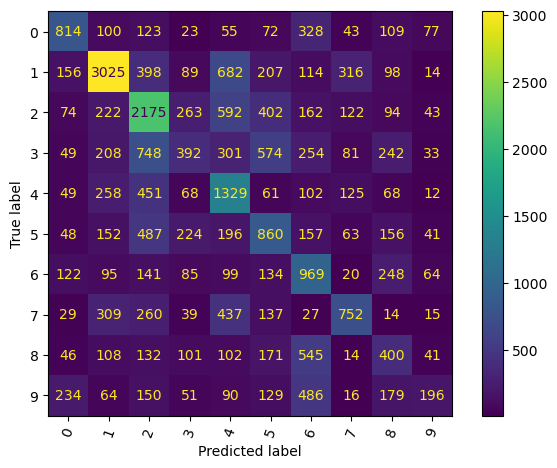

In [27]:
evaluate_model(model_vgg, 'VGG-16', VGG_test_loader)

In [28]:
from torchvision.models import ResNet18_Weights, resnet18
model_res = resnet18(weights=ResNet18_Weights)

/Users/tharun/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/tharun/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.3MB/s]


In [29]:
for param in model_res.parameters():
    param.requires_grad = False
model_res.fc = nn.Linear(in_features=512, out_features=10, bias=True)

In [30]:
ResNet_transformer = transforms.Compose([
    transforms.ToTensor()
])
ResNet_train_loader, ResNet_val_loader, ResNet_test_loader = load_data(
    ResNet_transformer, 'ResNet-18')

Using downloaded and verified file: ./Deep Learning/train_32x32.mat
Using downloaded and verified file: ./Deep Learning/test_32x32.mat


Shape: torch.Size([25, 3, 32, 32])


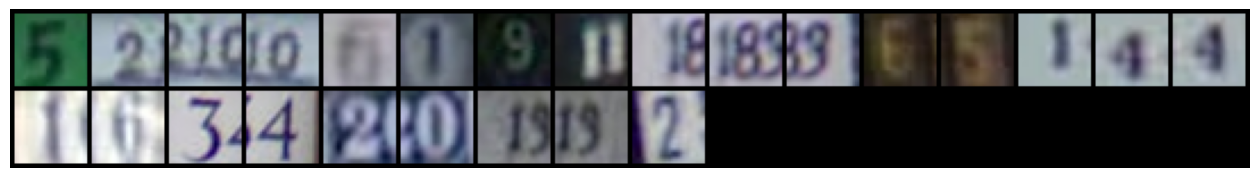

In [31]:
visualize(ResNet_test_loader)

Current Device: cpu
********************************************************************************
Now Training:: ResNet-18
********************************************************************************
Epoch:1	 Train_Loss: 2.0706	 Val_Loss: 2.0228	 Train_Acc: 0.2771	 Val_Acc: 0.3058	 Time: 505.06 seconds
Epoch:2	 Train_Loss: 2.0036	 Val_Loss: 2.0273	 Train_Acc: 0.3014	 Val_Acc: 0.3076	 Time: 529.55 seconds
Epoch:3	 Train_Loss: 1.9960	 Val_Loss: 2.0328	 Train_Acc: 0.3053	 Val_Acc: 0.3074	 Time: 544.32 seconds
Epoch:4	 Train_Loss: 1.9937	 Val_Loss: 2.0368	 Train_Acc: 0.3067	 Val_Acc: 0.3073	 Time: 554.14 seconds
Epoch:5	 Train_Loss: 1.9929	 Val_Loss: 2.0395	 Train_Acc: 0.3080	 Val_Acc: 0.3068	 Time: 537.83 seconds


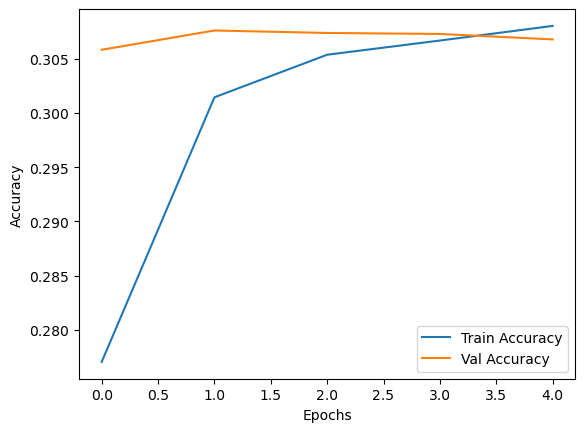

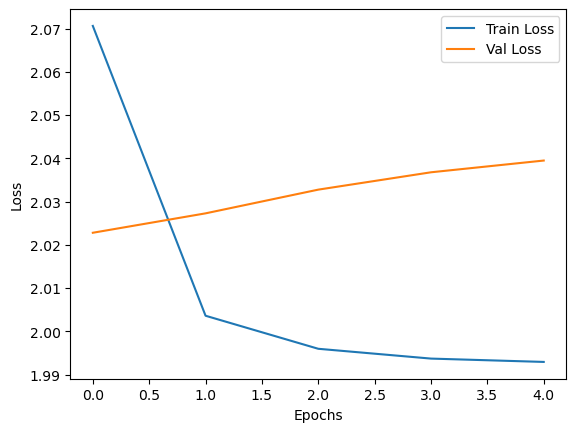

In [32]:
model_res = train_model(model_res, 'ResNet-18',
                        ResNet_train_loader, ResNet_val_loader)

Current Device: cpu
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.16      0.23      1744
           1       0.47      0.42      0.45      5099
           2       0.28      0.38      0.32      4149
           3       0.20      0.22      0.21      2882
           4       0.25      0.34      0.29      2523
           5       0.21      0.25      0.23      2384
           6       0.24      0.24      0.24      1977
           7       0.42      0.20      0.27      2019
           8       0.23      0.23      0.23      1660
           9       0.33      0.21      0.26      1595

    accuracy                           0.30     26032
   macro avg       0.31      0.26      0.27     26032
weighted avg       0.32      0.30      0.30     26032

Confusion Matrix:


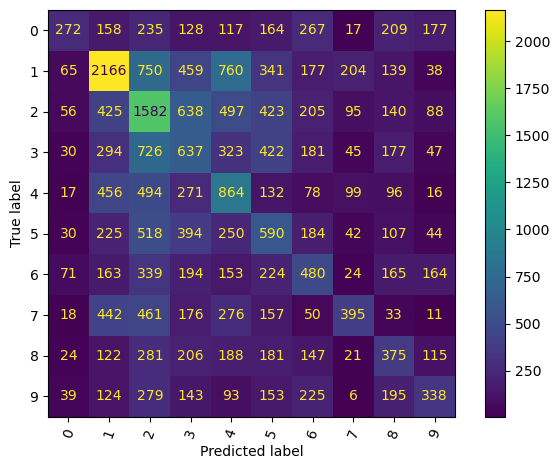

In [33]:
evaluate_model(model_res, 'ResNet-18', ResNet_test_loader)